# Compute correlation function with error bars using log-normal mocks

In [1]:
import time
from tqdm.notebook import tqdm

import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction, setup_logging
from mockfactory import EulerianLinearMock, LagrangianLinearMock, RandomBoxCatalog, setup_logging
from iminuit import Minuit

import catalog_data
import density_split

# To activate logging
setup_logging()

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
catalog_name = 'AbacusSummit_1Gpc_z1.175'
bias = 1.8

#catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')

## Generate log-normal mock

In [4]:
def generate_mock(nmesh, boxsize, boxcenter, seed, cosmology, nbar, z, bias, rsd=False, los=None, f=None, save=False, data_dir='', name='mock'):
    pklin = cosmology.get_fourier().pk_interpolator().to_1d(z)
    
    # unitary_amplitude forces amplitude to 1
    mock = LagrangianLinearMock(pklin, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=seed, unitary_amplitude=False)

    # this is Lagrangian bias, Eulerian bias - 1
    mock.set_real_delta_field(bias=bias - 1)
    mock.set_analytic_selection_function(nbar=nbar)
    mock.poisson_sample(seed=seed+1)
    #mock.set_rsd(f=f, los=los)
    data = mock.to_catalog()
    
    # Create Data instance
    positions = data['Position'].T % boxsize

    mock_catalog = catalog_data.Data(positions, z, boxsize, boxcenter, name=name)
    
    if save:
        mock_catalog.save(data_dir+name)
        
    return mock_catalog

In [5]:
t1 = time.time()
mock_catalog = generate_mock(nmesh=catalog.boxsize/2, boxsize=catalog.boxsize, boxcenter=catalog.boxcenter, seed=0, 
                             cosmology=fiducial.AbacusSummitBase(), nbar=catalog.size/catalog.boxsize**3, 
                             z=catalog.redshift, bias=bias)
t2 = time.time()

print('Execution time: {}s'.format(t2-t1))

[000019.45] [0/1] 04-28 12:03  LagrangianLinearMock      INFO     White noise generated.
[000037.62] [0/1] 04-28 12:04  LagrangianLinearMock      INFO     Poisson sampling done, total number of objects is 2932678.
[000044.82] [0/1] 04-28 12:04  LagrangianLinearMock      INFO     Catalog produced. Assigning in cell shift.
Execution time: 47.59642004966736s


## Compute two-point correlation function

In [6]:
def compute_2PCF(data, edges, los, save=False, name='mock'):
    result = TwoPointCorrelationFunction('smu', edges,
                                         data_positions1=data.positions,
                                         boxsize=data.boxsize,
                                         engine='corrfunc', nthreads=128,
                                         los = 'x')
    
    if save:
        result.save(output_dir+name+'_2PCF')
    
    return result

In [7]:
edges = (np.linspace(0., 150., 51), np.linspace(-1, 1, 201))

t1 = time.time()
catalog_2PCF = compute_2PCF(catalog, edges, los='x')
t2 = time.time()

print('Execution time: {}s'.format(t2-t1))

[000047.56] [0/1] 04-28 11:59  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000047.56] [0/1] 04-28 11:59  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000055.72] [0/1] 04-28 12:00  TwoPointCorrelationFunction INFO     Analytically computing two-point counts R1R2.
Execution time: 8.161661624908447s


In [8]:
t1 = time.time()
mock_catalog_2PCF = compute_2PCF(mock_catalog, edges, los='x')
t2 = time.time()

print('Execution time: {}s'.format(t2-t1))

[000055.90] [0/1] 04-28 12:00  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000055.91] [0/1] 04-28 12:00  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000064.05] [0/1] 04-28 12:00  TwoPointCorrelationFunction INFO     Analytically computing two-point counts R1R2.
Execution time: 8.146545171737671s


### Compare 2PCFs of abacus catalog and mock

In [9]:
ells = (0, 2)
nells = len(ells)


In [10]:
catalog_xiell = catalog_2PCF.get_corr(ells=ells, return_sep=False)
mock_xiell = mock_catalog_2PCF.get_corr(ells=ells, return_sep=False)

s = catalog_2PCF.seps[0][:, 0]

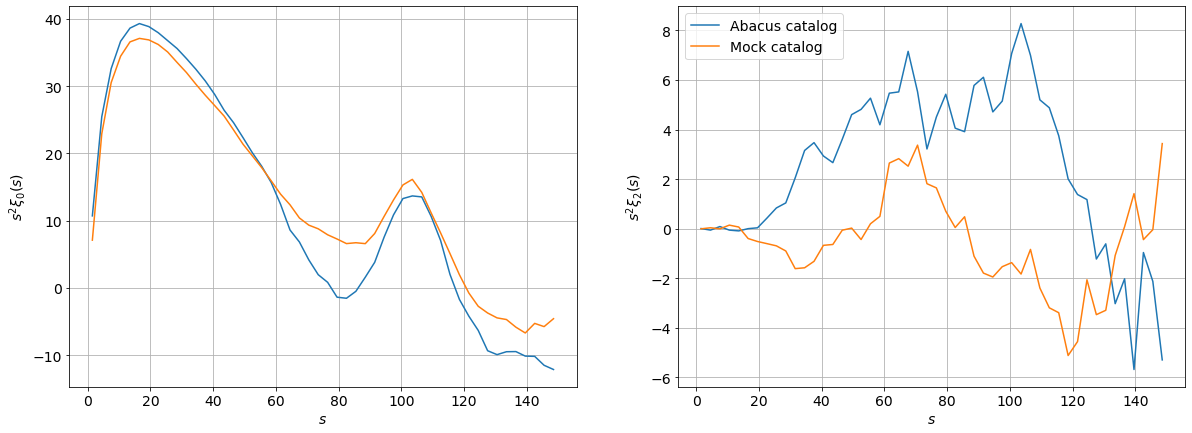

In [11]:
plt.rcParams["figure.figsize"] = (20, 7)

fig, axes = plt.subplots(1, nells)

for ill, ell in enumerate(ells):
    axes[ill].plot(s+ill*0.1, s**2 * catalog_xiell[ill], label='Abacus catalog')
    axes[ill].plot(s+ill*0.1, s**2 * mock_xiell[ill], label='Mock catalog')
    axes[ill].grid(True)
    axes[ill].set_xlabel(r'$s$')
    axes[ill].set_ylabel(r'$s^2 \xi_{}(s)$'.format(ell))
    
plt.legend()
plt.show()

## Generate N mocks and compute all 2PCFs

In [12]:
def generate_N_2PCF(catalog, nmocks, bias, save_each=False, output_dir=''):
    results = list()
    
    for i in tqdm(range(nmocks)):
        mock_catalog = generate_mock(nmesh=catalog.boxsize/4, boxsize=catalog.boxsize, boxcenter=catalog.boxcenter, seed=i,
                                     cosmology=fiducial.AbacusSummitBase(), nbar=catalog.size/catalog.boxsize**3,
                                     z=catalog.redshift, bias=bias,
                                     save=save_each, data_dir=output_dir, name='mock'+str(i))
        
        result = compute_2PCF(mock_catalog, edges, los='x')
        
        results.append(result)
        
    return results

In [13]:
results = generate_N_2PCF(catalog, nmocks=1000, bias=bias, save_each=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
np.save(output_dir+catalog.name+'_1000_mocks_2PCF', results)

In [15]:
s = results[0].seps[0][:, 0]

## Compute covariance matrix

In [16]:
def get_poles(results, ells):
    nells = len(ells)
    n = len(results)
    results_poles = [np.ravel(res.get_corr(ells=ells, return_sep=False)) for res in results]
    poles = np.mean(results_poles, axis=0)
    xiell = poles.reshape((nells, len(poles)//nells))
    cov = np.cov(results_poles, rowvar=False)

    return xiell, cov

In [17]:
ells = (0, 2)
nells = len(ells)

xiell, cov = get_poles(results, ells)

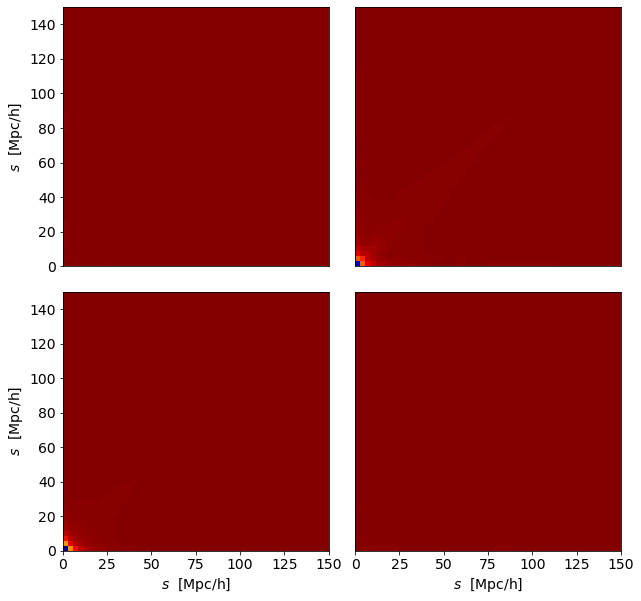

In [19]:
ns = len(s)

fig, lax = plt.subplots(nrows=nells, ncols=nells, sharex=False, sharey=False, figsize=(10,10), squeeze=False)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

from matplotlib.colors import Normalize
norm = Normalize(vmin=cov.min(), vmax=cov.max())
for i in range(nells):
    for j in range(nells):
        ax = lax[nells-1-i][j]
        mesh = ax.pcolor(s, s, cov[i*ns:(i+1)*ns,j*ns:(j+1)*ns].T, norm=norm, cmap=plt.get_cmap('jet_r'))
        if i>0: ax.xaxis.set_visible(False)
        else: ax.set_xlabel(r'$s$  [Mpc/h]')
        if j>0: ax.yaxis.set_visible(False)
        else: ax.set_ylabel(r'$s$  [Mpc/h]')
plt.show()

## Plot correlation function with error bars

In [20]:
catalog_xiell = catalog_2PCF.get_corr(ells=ells, return_sep=False)

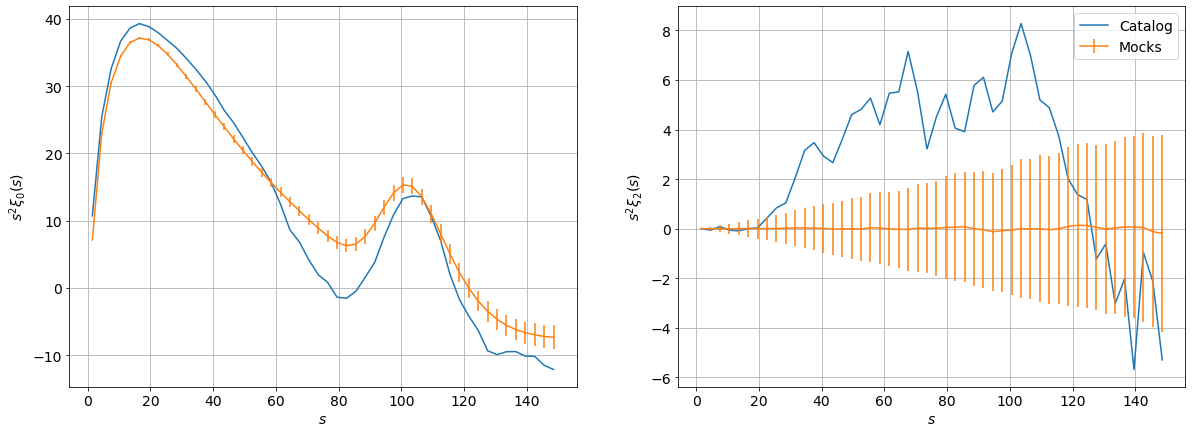

In [21]:
std = np.array_split(np.diag(cov)**0.5, nells)

plt.rcParams["figure.figsize"] = (20, 7)

fig, axes = plt.subplots(1, nells)

for ill,ell in enumerate(ells):
    axes[ill].plot(s+ill*0.1, s**2 * catalog_xiell[ill], ls='-', label='Catalog')
    axes[ill].errorbar(s+ill*0.1, s**2 * xiell[ill], s**2 * std[ill], fmt='-', label='Mocks')
    axes[ill].grid(True)
    axes[ill].set_xlabel(r'$s$')
    axes[ill].set_ylabel(r'$s^2 \xi_{}(s)$'.format(ell))
    
plt.legend()
plt.show()